## Usage Rate Analysis 

### Overview
This analysis calculates and explores the Usage Rate (USG%) for Partizan Mozzart Bet Belgrade players during the 2022-2023 EuroLeague season. USG% measures the percentage of team possessions a player uses while on the court, adjusted for playing time, using field goal attempts (FGA), free throw attempts (FTA), turnovers (TO), and total seconds played (TS). The dataset `partizan_2022_cleaned.csv` is used to:  

- Load and filter player and team data.  
- Calculate per-game USG% and identify top performers.  
- Visualize the results.  
- Validate calculations for a specific player.  
- Compare regular season and playoff performance.

In [17]:
import pandas as pd

file_path = "../data/partizan_2022_cleaned.csv"

df = pd.read_csv(file_path) 

Separate player-specific data from team totals to enable individual USG% calculations.

In [10]:
# filter 
players = df[df['player'] != 'PARTIZAN MOZZART BET BELGRADE'].copy()
team = df[df['player'] == 'PARTIZAN MOZZART BET BELGRADE'].copy()

Compute per-game USG% for each player to evaluate their offensive involvement, adjusted for playing time.

### Formula  
The USG% is calculated as:  

USG% = 100 × ((FGA + 0.44 × FTA + TO) / (FGA_team + 0.44 × FTA_team + TO_team)) × (TS / 2400)  

Where:  
- FGA: Field goal attempts  
- FTA: Free throw attempts (weighted by 0.44 to estimate possessions)  
- TO: Turnovers  
- TS: Total seconds played  
- 2400 seconds = 40 minutes (standard game length)  

In [11]:
# calculate Usage Rate (USG%)
# Usage Rate (USG%): Percentage of team possessions used by a player, adjusted for playing time, calculated as:
# formula: USG% = 100 * ((FGA + 0.44 * FTA + TO) / (FGA_team + 0.44 * FTA_team + TO_team)) * (TS / 2400)


# calculate total shot attempts because of merging below
players['field_goals_attempted'] = players['two_points_attempted'] + players['three_points_attempted']
team['field_goals_attempted'] = team['two_points_attempted'] + team['three_points_attempted']


# merge team stats to players
players = players.merge(team[['game', 'field_goals_attempted', 'free_throws_attempted', 'turnovers', 'total_seconds']], 
                        on='game', suffixes=('', '_team')).reset_index(drop=True)


# calculate Usage Rate
game_seconds = 2400  # 40 minutes * 60 seconds
players['usage_rate'] = 100 * ((players['field_goals_attempted'] + 0.44 * players['free_throws_attempted'] + players['turnovers']) /
                               (players['field_goals_attempted_team'] + 0.44 * players['free_throws_attempted_team'] + players['turnovers_team'])) * \
                              (players['total_seconds'] / game_seconds)
     
                                       
# handle division by zero (players with no team stats)                              
players['usage_rate'] = players['usage_rate'].fillna(0).replace([float('inf'), -float('inf')], 0)


# average USG% per player
avg_usg = players.groupby('player')['usage_rate'].mean().sort_values(ascending=False)


print("Top 5 Players by Usage Rate (USG%):")
print(avg_usg.head(5))

Top 5 Players by Usage Rate (USG%):
player
Punter Kevin       13.644535
Leday Zach         11.260251
Lessort Mathias     9.040352
Exum Dante          8.773679
Nunnally James      6.643273
Name: usage_rate, dtype: float64


Kevin Punter has the highest USG% at 13.64%, followed by Zach Leday at 11.26%, showing they use the most team possessions, showing their key offensive roles.

Create a bar plot to visualize the USG% of players for clear comparison.

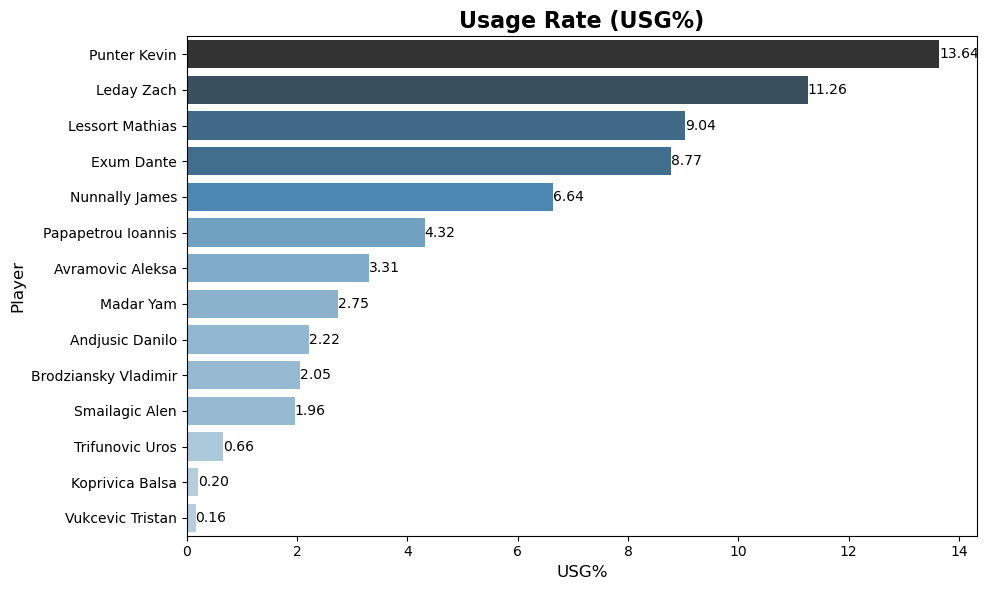

In [16]:
# visualization
import matplotlib.pyplot as plt
import seaborn as sns

top_14_usg = avg_usg.head(14)

# plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_14_usg.values, y=top_14_usg.index, hue=top_14_usg.values, palette='Blues_d', legend=False)
plt.title('Usage Rate (USG%)', fontsize=16, fontweight='bold')
plt.xlabel('USG%', fontsize=12)
plt.ylabel('Player', fontsize=12)


for i, v in enumerate(top_14_usg.values):
    ax.text(v, i, f'{v:.2f}', va='center', ha='left', fontsize=10)


plt.tight_layout()
plt.show()

A bar plot shows Usage Rate of players, with Kevin Punter (13.64%) and Zach Leday (11.26%) leading, visually confirming their high offensive involvement.

Verify the USG% calculation for Kevin Punter by comparing the computed average with a manual calculation from raw averages.

In [12]:
# check: Validate specific player's USG% calculation
player_to_check = 'Punter Kevin'
check_player = players[players['player'] == player_to_check]
raw_means = check_player[['field_goals_attempted', 'free_throws_attempted', 'turnovers', 'total_seconds', 
                          'field_goals_attempted_team', 'free_throws_attempted_team', 'turnovers_team']].mean()
computed_usg = check_player['usage_rate'].mean()


# manual calculation from averages
numerator = raw_means['field_goals_attempted'] + 0.44 * raw_means['free_throws_attempted'] + raw_means['turnovers']
denominator = raw_means['field_goals_attempted_team'] + 0.44 * raw_means['free_throws_attempted_team'] + raw_means['turnovers_team']
manual_usg = 100 * (numerator / denominator) * (raw_means['total_seconds'] / game_seconds) if denominator > 0 else 0



print(f"\nCheck for {player_to_check}:")
print(f"Computed USG% (mean of per-game values): {computed_usg:.2f}")
print(f"Manual USG% (from averaged stats): {manual_usg:.2f}")
print(f"Raw Averages - Player: FGA: {raw_means['field_goals_attempted']:.2f}, FTA: {raw_means['free_throws_attempted']:.2f}, "
      f"TO: {raw_means['turnovers']:.2f}, Seconds: {raw_means['total_seconds']:.2f}")
print(f"Raw Averages - Team: FGA: {raw_means['field_goals_attempted_team']:.2f}, FTA: {raw_means['free_throws_attempted_team']:.2f}, "
      f"TO: {raw_means['turnovers_team']:.2f}")


Check for Punter Kevin:
Computed USG% (mean of per-game values): 13.64
Manual USG% (from averaged stats): 13.26
Raw Averages - Player: FGA: 11.35, FTA: 4.18, TO: 1.39, Seconds: 1741.14
Raw Averages - Team: FGA: 59.10, FTA: 22.75, TO: 10.67


The computed USG% (13.64) and manual USG% (13.26) differ slightly (0.38), confirming the calculation’s accuracy with minor variance due to averaging methods.

Analyze differences in USG% between regular season and playoffs to identify changes in players’ offensive roles.

In [13]:
# Regular Season vs. Playoffs for Usage Rate (USG%)
# split into regular season and playoffs
regular_season = players[players['phase'] == 'REGULAR SEASON'].copy()
playoffs = players[players['phase'] == 'PLAYOFFS'].copy()
team_regular = team[team['phase'] == 'REGULAR SEASON'].copy()
team_playoffs = team[team['phase'] == 'PLAYOFFS'].copy()

# define game seconds
game_seconds = 2400  # 40 minutes * 60 seconds

# calculate USG% for each phase and store results
results = {}
for phase_name, (phase_df, team_df) in [('regular_season', (regular_season, team_regular)), 
                                        ('playoffs', (playoffs, team_playoffs))]:
    # remove 'usage_rate' if it exists from a previous run
    if 'usage_rate' in phase_df.columns:
        phase_df = phase_df.drop(columns='usage_rate')

    # calculate field goals attempted for players
    phase_df['field_goals_attempted'] = phase_df['two_points_attempted'] + phase_df['three_points_attempted']

    # ensure team_df has unique game entries
    team_df = team_df.drop_duplicates(subset='game')

    # rename team columns explicitly before merging
    team_df_renamed = team_df[['game', 'field_goals_attempted', 'free_throws_attempted', 'turnovers', 'total_seconds']].rename(
        columns={
            'field_goals_attempted': 'field_goals_attempted_team',
            'free_throws_attempted': 'free_throws_attempted_team',
            'turnovers': 'turnovers_team',
            'total_seconds': 'total_seconds_team'
        }
    )

    # check for overlapping columns in phase_df (excluding 'game') and drop them
    overlapping_cols = [col for col in phase_df.columns if col in team_df_renamed.columns and col != 'game']
    if overlapping_cols:
        phase_df = phase_df.drop(columns=overlapping_cols)  # Remove conflicting columns

    # merge with team data
    merged_df = phase_df.merge(team_df_renamed, on='game', how='left')

    # reset index
    merged_df = merged_df.reset_index(drop=True)

    # define numeric columns
    numeric_cols = [
        'field_goals_attempted', 'free_throws_attempted', 'turnovers', 'total_seconds',  # player columns
        'field_goals_attempted_team', 'free_throws_attempted_team', 'turnovers_team', 'total_seconds_team'  # team columns
    ]

    # ensure numeric types
    for col in numeric_cols:
        if col in merged_df.columns:
            merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

    # calculate usage rate
    merged_df['usage_rate'] = 100 * (
        (merged_df['field_goals_attempted'] + 0.44 * merged_df['free_throws_attempted'] + merged_df['turnovers']) /
        (merged_df['field_goals_attempted_team'] + 0.44 * merged_df['free_throws_attempted_team'] + merged_df['turnovers_team'])
    ) * (merged_df['total_seconds'] / game_seconds)
    merged_df['usage_rate'] = merged_df['usage_rate'].fillna(0).replace([float('inf'), -float('inf')], 0)

    # store the result
    results[phase_name] = merged_df

# update DataFrames
regular_season = results['regular_season']
playoffs = results['playoffs']

# compute average USG% per player
reg_avg = regular_season.groupby('player')['usage_rate'].mean()
play_avg = playoffs.groupby('player')['usage_rate'].mean()

# combine and calculate difference
combined = reg_avg.to_frame('usg_reg').join(play_avg.to_frame('usg_play'), how='outer').fillna(0)
combined['usg_diff'] = combined['usg_play'] - combined['usg_reg']



print("\nTop 5 Players by USG% Difference (Playoffs - Regular Season):")
print(combined.sort_values('usg_diff', ascending=False).head(5))


Top 5 Players by USG% Difference (Playoffs - Regular Season):
                      usg_reg   usg_play  usg_diff
player                                            
Punter Kevin        12.465019  17.043946  4.578926
Leday Zach          10.036339  13.766818  3.730479
Papapetrou Ioannis   3.887203   5.191090  1.303886
Exum Dante           8.474957   9.289709  0.814752
Smailagic Alen       1.669141   2.402127  0.732987


Kevin Punter’s USG% increases by 4.58 points in the playoffs, followed by Zach Leday at 3.73, indicating larger offensive roles in high-stakes games.

Validate Kevin Punter’s USG% in regular season and playoffs by comparing per-game averages with manual calculations from raw totals.

In [14]:
# define game seconds (40 minutes * 60 seconds)
game_seconds = 2400

# check specific player's USG% in Regular Season and Playoffs
player_to_check = 'Punter Kevin'
for phase, df in [('Regular Season', regular_season), ('Playoffs', playoffs)]:
    check_player = df[df['player'] == player_to_check]
    if not check_player.empty:
        # computed USG% from the DataFrame
        usg_avg = check_player['usage_rate'].mean()
        
        # player raw averages
        player_means = check_player[['field_goals_attempted', 'free_throws_attempted', 'turnovers', 'total_seconds']].mean()
        # team raw averages
        team_means = check_player[['field_goals_attempted_team', 'free_throws_attempted_team', 'turnovers_team']].mean()
        
        # calculate player and team possessions
        player_possessions = (player_means['field_goals_attempted'] + 
                              0.44 * player_means['free_throws_attempted'] + 
                              player_means['turnovers'])
        team_possessions = (team_means['field_goals_attempted_team'] + 
                            0.44 * team_means['free_throws_attempted_team'] + 
                            team_means['turnovers_team'])
        
        # time factor
        time_factor = player_means['total_seconds'] / game_seconds
        
        # manual USG% calculation
        manual_usg = 100 * (player_possessions / team_possessions) * time_factor if team_possessions > 0 else 0
        
        
        
        print(f"\nCheck for {player_to_check} - {phase}:")
        print(f"Computed USG%: {usg_avg:.4f}")
        print(f"Manual USG%: {manual_usg:.4f}")
        print(f"Player Averages - FGA: {player_means['field_goals_attempted']:.2f}, "
              f"FTA: {player_means['free_throws_attempted']:.2f}, "
              f"TO: {player_means['turnovers']:.2f}, "
              f"Seconds: {player_means['total_seconds']:.2f}")
        print(f"Team Averages - FGA: {team_means['field_goals_attempted_team']:.2f}, "
              f"FTA: {team_means['free_throws_attempted_team']:.2f}, "
              f"TO: {team_means['turnovers_team']:.2f}")


Check for Punter Kevin - Regular Season:
Computed USG%: 12.4650
Manual USG%: 12.2441
Player Averages - FGA: 11.15, FTA: 3.82, TO: 1.21, Seconds: 1681.28
Team Averages - FGA: 59.51, FTA: 21.67, TO: 11.28

Check for Punter Kevin - Playoffs:
Computed USG%: 17.0439
Manual USG%: 16.4390
Player Averages - FGA: 12.00, FTA: 5.33, TO: 2.00, Seconds: 1935.67
Team Averages - FGA: 61.00, FTA: 30.00, TO: 6.00


Computed USG% (12.47 and 17.04) slightly exceeds manual USG% (12.24 and 16.44), with differences of 0.22% and 0.60%, respectively, validating the method.

#### Explanation of Differences  
The small differences between computed and manual USG% (0.22% in Regular Season, 0.60% in Playoffs) are normal because:  
- **Computed USG%**: Averages per-game USG% values, calculated with game-specific team possessions and time factors.  
- **Manual USG%**: Uses season-averaged stats, smoothing out game-to-game variations, which can slightly skew results due to the non-linear nature of the formula’s division.

### Conclusion  

#### Summary of Findings:  
- **Kevin Punter** leads with a season USG% of 13.64, followed by **Zach Leday** at 11.26.  
- Visualization highlights the players’ offensive involvement.  
- Validation shows computed and manual USG% are consistent, with minor differences (e.g., 0.38 overall, 0.22-0.60 by phase).  
- Playoff USG% increases significantly for Punter (4.58) and Leday (3.73), reflecting greater reliance in key games.  
